In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras 
from keras.applications import inception_resnet_v2
from keras.layers import GlobalAveragePooling2D,Dense
from keras.models import Sequential
from keras.utils import to_categorical 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import seaborn as sns 
import glob 
import cv2
import pathlib
from tqdm import tqdm

In [2]:
dataset = pathlib.Path('lung_colon_image_set/colon_image_sets/')
images = list(dataset.glob('*/*.jpeg'))

cacc = dataset.glob('colon_aca/*')
cbt = dataset.glob('colon_n/*')

colon_adenocarcinoma = list(cacc)
colon_benign_tissue = list(cbt)

In [3]:
label_dict = {
    'colon_adenocarcinoma' : 0,
    'colon_benign_tissue' : 1
}

image_dict = {
    'colon_adenocarcinoma' : colon_adenocarcinoma,
    'colon_benign_tissue' :colon_benign_tissue
}

In [4]:
x,y = [],[]

for name,images in tqdm(image_dict.items(), desc='Processing Images'):
    for i in tqdm(images, desc=f'Processing {name} Images', leave=False):
        img = cv2.imread(str(i))
        re_img = cv2.resize(img,(200,200))
        re_img=np.round((re_img.astype(np.float16)/255.0),4)
        x.append(re_img)
        y.append(label_dict[name])

x = np.array(x)
y = np.array(y)

Processing Images: 100%|██████████| 2/2 [01:42<00:00, 51.44s/it]


In [5]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=10)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test,test_size=0.5,random_state=10)
x_train.shape

(5600, 200, 200, 3)

In [6]:
model = Sequential()
inc_res_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet',include_top=False,input_shape=(200,200,3))
model.add(inc_res_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(2,activation='softmax'))

for layer in inc_res_model.layers:
    layer.trainable = False

y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test,num_classes=2)
y_val_cat = to_categorical(y_val,num_classes=2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 4, 4, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 54339810 (207.29 MB)
Trainable params: 3074 (12.01 KB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [7]:
history = model.fit(x_train,y_train_cat,validation_data=(x_val,y_val_cat),epochs=10,batch_size=8)

Epoch 1/10
700/700 [==============================] - 385s 533ms/step - loss: 0.0563 - accuracy: 0.9796 - val_loss: 0.0172 - val_accuracy: 0.9933
Epoch 2/10
700/700 [==============================] - 358s 512ms/step - loss: 0.0222 - accuracy: 0.9916 - val_loss: 0.0161 - val_accuracy: 0.9967
Epoch 3/10
700/700 [==============================] - 358s 511ms/step - loss: 0.0135 - accuracy: 0.9955 - val_loss: 0.0103 - val_accuracy: 0.9967
Epoch 4/10
700/700 [==============================] - 359s 513ms/step - loss: 0.0117 - accuracy: 0.9954 - val_loss: 0.0111 - val_accuracy: 0.9958
Epoch 5/10
700/700 [==============================] - 360s 515ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.0155 - val_accuracy: 0.9942
Epoch 6/10
700/700 [==============================] - 361s 516ms/step - loss: 0.0115 - accuracy: 0.9952 - val_loss: 0.0082 - val_accuracy: 0.9967
Epoch 7/10
700/700 [==============================] - 380s 544ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.0218 -

In [8]:
hist = pd.DataFrame(history.history)

In [9]:
model.evaluate(x_test,y_test_cat)

38/38 [==============================] - 64s 2s/step - loss: 0.0072 - accuracy: 0.9983


[0.007220595609396696, 0.9983333349227905]

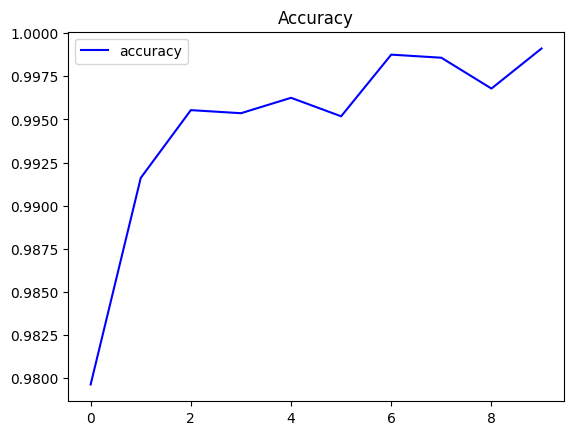

In [10]:
plt.plot(history.history['accuracy'],color='blue',label='accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

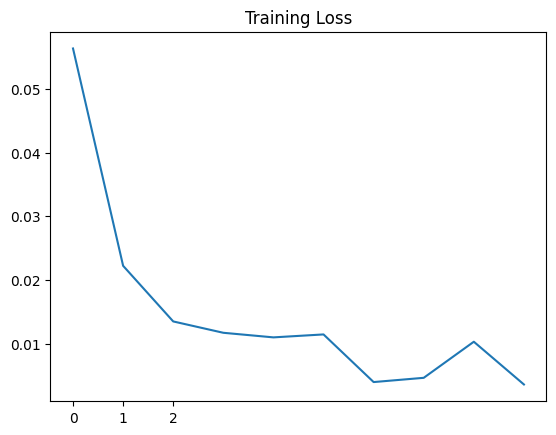

In [11]:
x=list(range(0,3))
plt.plot(hist['loss'])
plt.xticks(x)
plt.title("Training Loss")
plt.show()

In [12]:
model.save("model2.h5")

c:\Users\abi\Desktop\abijith\DeepLearning\DL\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
